In [1]:
# Python ≥3.5 is required
import sys

import keras.datasets.mnist

print("Python: ", sys.version_info)
assert sys.version_info >= (3, 7)

# Scikit-Learn ≥0.20 is required
import sklearn
print("sklearn version: ", sklearn.__version__)
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.8 is required
import tensorflow as tf
print("TF version: ", tf.__version__)
# assert tf.__version__ >= "2.8"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# GPU test
print("GPU installed: ",tf.test.is_built_with_gpu_support())

# To prevent "CUDNN_STATUS_ALLOC_FAILED" error with GPUs
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

# Common imports
import numpy as np
import os
import pandas as pd
import tensorflow_datasets as tfds
from tensorflow_datasets.core.utils import gcs_utils
gcs_utils._is_gcs_disabled = True


# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "ann"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

2024-05-21 02:47:26.039349: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-21 02:47:26.039394: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-21 02:47:26.040040: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-21 02:47:26.047998: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-21 02:47:26.783827: W tensorflow/compiler/tf2

Python:  sys.version_info(major=3, minor=9, micro=19, releaselevel='final', serial=0)
sklearn version:  1.4.1.post1
TF version:  2.15.0
GPU installed:  True
1 Physical GPUs, 1 Logical GPUs


2024-05-21 02:47:28.264045: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-21 02:47:28.304605: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-21 02:47:28.304674: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-21 02:47:28.305839: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-21 02:47:28.305875: I external/local_xla/xla/stream_executor

In [2]:
from pathlib import Path

IMAGES_PATH = Path() / "images" / "deep"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    savefig = plt.savefig(path, format=fig_extension, dpi=resolution)

In [3]:
import tensorflow_datasets as tfds

tfds.__version__

'4.9.3+nightly'

In [4]:
! pip install --upgrade tfds-nightly

/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)


## get the data(EMNIST)

In [5]:
import tensorflow_datasets as tfds

(train_data, valid_data, test_data), info = tfds.load("emnist/byclass", split=["train[:80%]", "train[80%:]", "test"], as_supervised=True, with_info=True)

train, test = tfds.load("emnist/byclass", split=["train", "test"], as_supervised=True)

In [6]:
sys.getrecursionlimit()

3000

In [7]:
print(f"size of train: {train_data.cardinality().numpy()}")
print(f"size of validation: {valid_data.cardinality().numpy()}")
print(f"size of test: {test_data.cardinality().numpy()}")

size of train: 558346
size of validation: 139586
size of test: 116323


In [8]:
num_class = info.features["label"].num_classes
print(num_class)

62


## prepare the data

In [9]:
def preprocess_lenet5(image, label):
    # Resize image to (32, 32, 1)
    image = tf.image.resize(image, size=(32, 32))
    # Rescale pixel values to [0, 1]
    image = tf.cast(image, tf.float64) / 255.0
    return image, label

In [10]:
train_data = train_data.map(preprocess_lenet5)
valid_data = valid_data.map(preprocess_lenet5)
test_data = test_data.map(preprocess_lenet5)

In [11]:
# Batch and prefetch the datasets
batch_size = 32
train_data = train_data.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
valid_data = valid_data.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
test_data = test_data.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

## train / evaluate lenet5

In [12]:
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPool2D, AvgPool2D

class LeNet(Sequential):
    def __init__(self,num_classes):
        super().__init__()

        self.add(Conv2D(6,5,strides=1,activation='relu',input_shape=(32,32,1),padding='same'))
        self.add(AvgPool2D(2,strides=2))
        self.add(Conv2D(16,5,strides=1,activation='relu'))
        self.add(AvgPool2D(2,strides=2))
        self.add(Conv2D(120,5,strides=1,activation='relu'))
        self.add(Flatten())
        self.add(Dense(84,activation='tanh'))
        self.add(Dense(num_classes,activation='softmax'))
    
        self.compile(optimizer='adam',
                     loss='sparse_categorical_crossentropy',
                     metrics='accuracy')

In [13]:
model = LeNet(num_class)
model.summary()

Model: "le_net"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 6)         156       
                                                                 
 average_pooling2d (Average  (None, 16, 16, 6)         0         
 Pooling2D)                                                      
                                                                 
 conv2d_1 (Conv2D)           (None, 12, 12, 16)        2416      
                                                                 
 average_pooling2d_1 (Avera  (None, 6, 6, 16)          0         
 gePooling2D)                                                    
                                                                 
 conv2d_2 (Conv2D)           (None, 2, 2, 120)         48120     
                                                                 
 flatten (Flatten)           (None, 480)               0    

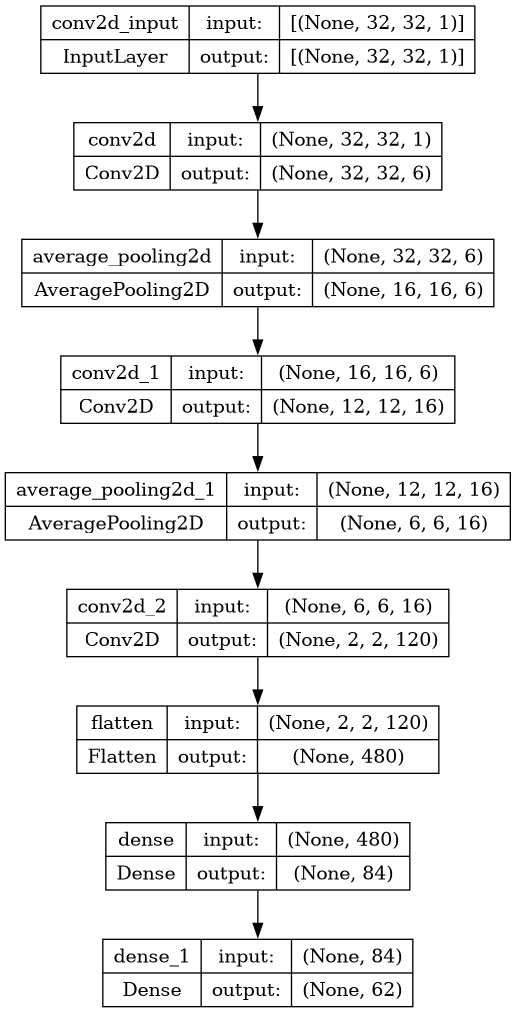

In [14]:
tf.keras.utils.plot_model(model, "LeNet5.png", show_shapes=True)

In [15]:
history = model.fit(train_data, epochs=5, validation_data=valid_data, batch_size=128)

Epoch 1/5


2024-05-21 02:57:58.158813: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-05-21 02:57:58.801339: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f06bc3485b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-05-21 02:57:58.801384: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3070, Compute Capability 8.6
2024-05-21 02:57:58.812321: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1716227878.892482  125755 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


17449/17449 [==============================] - 93s 5ms/step - loss: 0.5288 - accuracy: 0.8202 - val_loss: 0.4289 - val_accuracy: 0.8456
Epoch 2/5
17449/17449 [==============================] - 93s 5ms/step - loss: 0.3995 - accuracy: 0.8533 - val_loss: 0.4044 - val_accuracy: 0.8530
Epoch 3/5
17449/17449 [==============================] - 94s 5ms/step - loss: 0.3768 - accuracy: 0.8597 - val_loss: 0.3964 - val_accuracy: 0.8558
Epoch 4/5
17449/17449 [==============================] - 93s 5ms/step - loss: 0.3638 - accuracy: 0.8634 - val_loss: 0.3946 - val_accuracy: 0.8566
Epoch 5/5
17449/17449 [==============================] - 95s 5ms/step - loss: 0.3552 - accuracy: 0.8659 - val_loss: 0.3963 - val_accuracy: 0.8559


In [18]:
def plot_history_acc(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'validation'])
    plt.show()
    
def plot_history_loss(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'validation'])
    plt.show()   

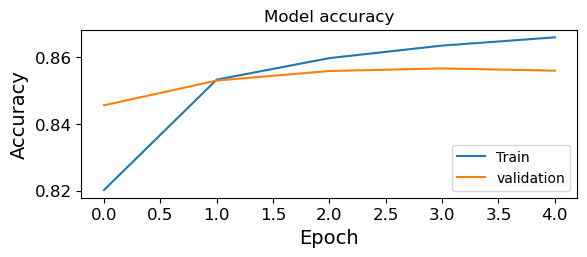

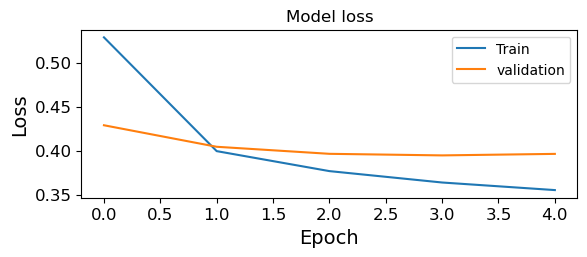

In [19]:
plt.subplot(211)
plot_history_acc(history)
plt.subplot(212)
plot_history_loss(history)

## evaluate the model

In [30]:
model.evaluate(test_data)

3636/3636 [==============================] - 11s 3ms/step - loss: 0.4044 - accuracy: 0.8529


[0.4044412672519684, 0.8529353737831116]

TODO:
1. callback 추가(earlystopping 등)
2. tensorboard로 model training 시각화(교재 참고) 